In [1]:
%matplotlib inline

Prepare custom datasets for object detection
===============================================

With GluonCV, we have already provided built-in support for widely used public datasets with zero
effort, e.g. `sphx_glr_build_examples_datasets_pascal_voc.py` and `sphx_glr_build_examples_datasets_mscoco.py`.

However it is very natural to create a custom dataset of your choice for object detection tasks.

This tutorial is intend to provide you some hints to clear the path for you.
In practice, feel free to choose whatever method that fits for your use case best.

`lst_record_dataset`

`pascal_voc_like`




1. Preferred Object Detection Format for GluonCV and MXNet
----------------------------------------------------------
Let us walk through some fundamental backgrounds in case you are not familiar with them.

Bounding Boxes
^^^^^^^^^^^^^^

There are multiple ways to organize the label format for object detection task. We will briefly introduce the
most widely used: ``bounding box``.

GluonCV expect all bounding boxes to be encoded as (xmin, ymin, xmax, ymax), aka (left, top, right, bottom) borders of each object of interest.

First of all, let us plot a real image for example:



In [3]:
import os, zipfile
from gluoncv import utils
import mxnet as mx
import numpy as np
from matplotlib import pyplot as plt

im_fname = utils.download('https://github.com/dmlc/web-data/blob/master/' +
                          'gluoncv/datasets/dog.jpg?raw=true',
                          path='dog.jpg')
img = mx.image.imread(im_fname)
ax = utils.viz.plot_image(img)
print(img.shape)
plt.show()

100%|██████████| 160/160 [00:00<00:00, 2793.71KB/s]

(576, 768, 3)


<Figure size 640x480 with 1 Axes>

Now, let's label the image manually for demo.

.. hint::

   In practice, a dedicated GUI labeling tool is more convenient.

We expect all bounding boxes follow this format: (xmin, ymin, xmax, ymax)



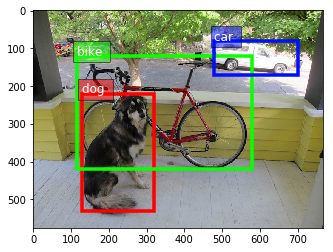

In [4]:
dog_label = [130, 220, 320, 530]
bike_label = [115, 120, 580, 420]
car_label = [480, 80, 700, 170]
all_boxes = np.array([dog_label, bike_label, car_label])
all_ids = np.array([0, 1, 2])
class_names = ['dog', 'bike', 'car']

# see how it looks by rendering the boxes into image
ax = utils.viz.plot_bbox(img, all_boxes, labels=all_ids, class_names=class_names)
plt.show()

LST Label for GluonCV and MXNet
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Following the convention used in MXNet, we recommand a LST file which is a plain text list file to store labels.

LST file was first introduced in MXNet following the `RecordIO design <https://mxnet.incubator.apache.org/architecture/note_data_loading.html>`_ and the `List file tutorial <https://mxnet.incubator.apache.org/faq/recordio.html>`_ of creating a LST file.

.. hint::

  The benefits of using single LST file are two fold:

  1. It's easier to manege single file rather than scattered annotation files.

  2. It's compatible with ``RecordFile`` binary format which we will cover in this tutorial later.

The format of LST file is:



In [ ]:
"""
integer_image_index \t label_of_variable_length \t relative_path_to_image
"""

Typically, we take the list of names of all images, shuffles them, then separates them into two lists: a training filename list and a testing filename list.

Here we use compatible format for object detection task as `mxnet.image.ImageDetIter <https://mxnet.apache.org/api/python/image/image.html#image-iterator-for-object-detection>`_.

`mxnet.image.ImageDetIter` is a object detection data iterator written in C++ which includes tons of augmentation choices. However, it's not flexible enough to handle all kinds of customized data augmentation.
As a result, in GluonCV, we switched to :py:mod:`gluoncv.data.transforms` to support almost all types of data augmentations.

More specifically, the label of object detection task is described as follows:

![](https://github.com/dmlc/web-data/blob/master/gluoncv/datasets/detection_label.png?raw=true)


![](https://github.com/dmlc/web-data/blob/master/gluoncv/datasets/detection_label_detail.png?raw=true)


So, the corresponding LST file for the image we just labeled can be formatted as:



In [5]:
def write_line(img_path, im_shape, boxes, ids, idx):
    h, w, c = im_shape
    # for header, we use minimal length 2, plus width and height
    # with A: 4, B: 5, C: width, D: height
    A = 4
    B = 5
    C = w
    D = h
    # concat id and bboxes
    labels = np.hstack((ids.reshape(-1, 1), boxes)).astype('float')
    # normalized bboxes (recommanded)
    labels[:, (1, 3)] /= float(w)
    labels[:, (2, 4)] /= float(h)
    # flatten
    labels = labels.flatten().tolist()
    str_idx = [str(idx)]
    str_header = [str(x) for x in [A, B, C, D]]
    str_labels = [str(x) for x in labels]
    str_path = [img_path]
    line = '\t'.join(str_idx + str_header + str_labels + str_path) + '\n'
    return line

A single line may be long, but contains complete information of each image required by object detection.

The length of each line varies, depending on how many objects are labeled inside the corresponding image.

By stacking lines one by one, it is very nature to create ``train.lst`` and ``val.lst`` for training/validation purposes.

In this tutorial, we repeat the same image 4 times to create a fake ``val.lst`` file.



In [6]:
with open('val.lst', 'w') as fw:
    for i in range(4):
        line = write_line('dog.jpg', img.shape, all_boxes, all_ids, i)
        print(line)
        fw.write(line)

0	4	5	768	576	0.0	0.16927083333333334	0.3819444444444444	0.4166666666666667	0.9201388888888888	1.0	0.14973958333333334	0.20833333333333334	0.7552083333333334	0.7291666666666666	2.0	0.625	0.1388888888888889	0.9114583333333334	0.2951388888888889	dog.jpg

1	4	5	768	576	0.0	0.16927083333333334	0.3819444444444444	0.4166666666666667	0.9201388888888888	1.0	0.14973958333333334	0.20833333333333334	0.7552083333333334	0.7291666666666666	2.0	0.625	0.1388888888888889	0.9114583333333334	0.2951388888888889	dog.jpg

2	4	5	768	576	0.0	0.16927083333333334	0.3819444444444444	0.4166666666666667	0.9201388888888888	1.0	0.14973958333333334	0.20833333333333334	0.7552083333333334	0.7291666666666666	2.0	0.625	0.1388888888888889	0.9114583333333334	0.2951388888888889	dog.jpg

3	4	5	768	576	0.0	0.16927083333333334	0.3819444444444444	0.4166666666666667	0.9201388888888888	1.0	0.14973958333333334	0.20833333333333334	0.7552083333333334	0.7291666666666666	2.0	0.625	0.1388888888888889	0.9114583333333334	0.29513888888888

LstDetection for Loading Raw Images in Folders
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

Assume the relative root path to the image folder is current directory



In [7]:
from gluoncv.data import LstDetection
lst_dataset = LstDetection('val.lst', root=os.path.expanduser('.'))
print('length:', len(lst_dataset))
first_img = lst_dataset[0][0]
print('image shape:', first_img.shape)
print('Label example:')
print(lst_dataset[0][1])
print("GluonCV swaps bounding boxes to columns 0-3 by default")

length: 4
image shape: (576, 768, 3)
Label example:
[[130. 220. 320. 530.   0.]
 [115. 120. 580. 420.   1.]
 [480.  80. 700. 170.   2.]]
GluonCV swaps bounding boxes to columns 0-3 by default


RecordFileDetection for Entire Dataset Packed in Signle MXNet RecordFile
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

Reading scattered images in folders can be slow, due to constraint of disk random access speed.
There's a significant gap between random/sequential access speed especially on HDDs.
Even with modern PCI-E based Solid State Drives, sequential reading IO performance still blows
random reading by a large margin.

We will skip repeating the design of RecordIO built into MXNet, if you are interested, have a look at `RecordIO design <https://mxnet.incubator.apache.org/architecture/note_data_loading.html>`_.

In this section, we go through the fundamental steps to create a record file.

First of all, you will need a ``im2rec.py`` file to start with.



.. hint::

     You can find `im2rec.py` in `incubator-mxnet/tools/ <https://github.com/apache/incubator-mxnet/blob/master/tools/im2rec.py>`_, or you can simply download it now.

     Usage:

     .. code-block:: bash

         python im2rec.py lst_file_name relative_root_to_images --pass-through --pack-label

     Some important arguments to the ``im2rec.py``:

          - ``--pass-through``: no transcode of original image, pack it to binary as is. It will preserve original quality and aspect ratio anyway.

          - ``--pack-label``: pack the labels in lst file to binary record file, so ``.rec`` file is self compelete.




In [8]:
import sys
import subprocess
im2rec = utils.download('https://raw.githubusercontent.com/apache/incubator-mxnet/' +
                        '6843914f642c8343aaa9a09db803b6af6f5d94a2/tools/im2rec.py', 'im2rec.py')
subprocess.check_output([sys.executable, 'im2rec.py', 'val', '.', '--no-shuffle', '--pass-through', '--pack-label'])

100%|██████████| 4/4 [00:00<00:00, 678.17KB/s]


b'Creating .rec file from /home/pythxnbite/Downloads/real-time-object-detection/val.lst in /home/pythxnbite/Downloads/real-time-object-detection\nmultiprocessing not available, fall back to single threaded encoding\ntime: 0.0008864402770996094  count: 0\n'

Now similarly, we can create a dataset from the binary file we just created with on line of code:



In [9]:
from gluoncv.data import RecordFileDetection
record_dataset = RecordFileDetection('val.rec', coord_normalized=True)

# we expect same results from LstDetection
print('length:', len(record_dataset))
first_img = record_dataset[0][0]
print('image shape:', first_img.shape)
print('Label example:')
print(record_dataset[0][1])

length: 4
image shape: (576, 768, 3)
Label example:
[[130. 220. 320. 530.   0.]
 [115. 120. 580. 420.   1.]
 [480.  80. 700. 170.   2.]]



2. Derive from PASCAL VOC format
--------------------------------
It you have a custom dataset fully comply with the `Pascal VOC <http://host.robots.ox.ac.uk/pascal/VOC/>`_ object detection format,
that could be good news, because it's can be adapted to GluonCV format real quick.

We provide a template for you to peek the structures



In [10]:
fname = utils.download('https://github.com/dmlc/web-data/blob/master/gluoncv/datasets/VOCtemplate.zip?raw=true', 'VOCtemplate.zip')
with zipfile.ZipFile(fname) as zf:
    zf.extractall('.')

100%|██████████| 79/79 [00:00<00:00, 2210.71KB/s]


A VOC-like dataset will have the following structure:




In [11]:
"""
VOCtemplate
└── VOC2018
    ├── Annotations
    │   └── 000001.xml
    ├── ImageSets
    │   └── Main
    │       └── train.txt
    └── JPEGImages
        └── 000001.jpg
"""

'\nVOCtemplate\n└── VOC2018\n    ├── Annotations\n    │\xa0\xa0 └── 000001.xml\n    ├── ImageSets\n    │\xa0\xa0 └── Main\n    │\xa0\xa0     └── train.txt\n    └── JPEGImages\n        └── 000001.jpg\n'

And an example of annotation file:



In [12]:
with open('VOCtemplate/VOC2018/Annotations/000001.xml', 'r') as fid:
    print(fid.read())

<annotation>
	<filename>000001.jpg</filename>
	<size>
		<width>353</width>
		<height>500</height>
		<depth>3</depth>
	</size>
	<object>
		<name>dog</name>
		<difficult>0</difficult>
		<bndbox>
			<xmin>48</xmin>
			<ymin>240</ymin>
			<xmax>195</xmax>
			<ymax>371</ymax>
		</bndbox>
	</object>
	<object>
		<name>person</name>
		<difficult>0</difficult>
		<bndbox>
			<xmin>8</xmin>
			<ymin>12</ymin>
			<xmax>352</xmax>
			<ymax>498</ymax>
		</bndbox>
	</object>
</annotation>



As long as your dataset can match the PASCAL VOC convension, it is convenient to
derive custom dataset from ``VOCDetection``



In [13]:
from gluoncv.data import VOCDetection
class VOCLike(VOCDetection):
    CLASSES = ['person', 'dog']
    def __init__(self, root, splits, transform=None, index_map=None, preload_label=True):
        super(VOCLike, self).__init__(root, splits, transform, index_map, preload_label)

dataset = VOCLike(root='VOCtemplate', splits=((2018, 'train'),))
print('length of dataset:', len(dataset))
print('label example:')
print(dataset[0][1])

length of dataset: 1
label example:
[[ 47. 239. 194. 370.   1.   0.]
 [  7.  11. 351. 497.   0.   0.]]


The last column indicate the difficulties of labeled object
You can ignore the following section if it's out of your intention in the xml file:



In [ ]:
"""<difficult>0</difficult>"""